# Deal with Data

## 1. 处理最初的数据集

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

url = '/mnt/data/Project7/fakenews/csv/'
# 将时间局限在事件范围内的所有帖子都取出来.
# 这一步可能需要使用肉眼来观察这个时间的范围
# 可以通过 create_at 这个属性来看到这个帖子的发布时间

In [2]:
df = pd.read_csv(url+'1.csv') # or 2.csv 3.csv...取决去topic所选择的时间
# 需要通过 create_at 这个属性来看到这个帖子的发布时间,然后选择出这个时间段的所有数据
# 当然也可以通过最开始 选择限定时间数据集的方法来限定时间

start = 3090000 # 这个数值得根据时间做更改
df = df.iloc[start:] # 这里是将时间限定在一定范围内

/tmp/ipykernel_3764872/659677461.py:1: DtypeWarning: Columns (27,28,29,31,39,41,42,43,49,65,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url+'1.csv') # or 2.csv 3.csv...取决去topic所选择的时间


In [34]:
# 选择出相应的人群
high = pd.read_csv('high.csv',index_col=0)['Id'].to_list()
low = pd.read_csv('low.csv',index_col=0)['Id'].to_list()

In [4]:
def filter_data_by_users(df:pd.DataFrame, userlist: list ,title:str):
    """
    df: 为限定完时间段的数据集
    userlist: 为峰的user名单
    title: 命名名单,保存为 'users[title]][alltweets].csv'
    """
    df = df[df['author.username'].isin(userlist)]
    df = df[['id','conversation_id','author.username','referenced_tweets.replied_to.id','referenced_tweets.retweeted.id','referenced_tweets.quoted.id','text']]
    df.to_csv(f'users[{title}]][alltweets].csv')
    return df

def filter_author_tweet(df:pd.DataFrame) -> pd.DataFrame:
    """
    筛选出users们中texts中, 其中他们发布的帖子
    返回其发帖的dataframe
    """
    df_only_author = df[df['referenced_tweets.retweeted.id'].isna()]
    df_only_author = df_only_author[df_only_author['referenced_tweets.quoted.id'].isna()]
    df_only_author = df_only_author[df_only_author['referenced_tweets.replied_to.id'].isna()]
    return df_only_author

def filter_url(df:pd.DataFrame) -> pd.DataFrame:
    """
    对其发帖中的url进行处理, 删去其中的url
    """
    def wordopt(text):
        text = text.lower()
        # text = re.sub('\\n', '', text) # 删除换行符
        # text = re.sub('\[.*?\]', '', text) # 去掉中括号括起来的字符串
        text = re.sub('https?://\S+|www\.\S+', '', text) # 去掉网址
        # text = re.sub("\\W"," ",text) # 去掉非单词字符
        # text = re.sub('<.*?>+', '', text) # 去掉HTML, XML标签
        # text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # 将文本中所有标点符号删除
        # text = re.sub('\n', '', text) # 删除换行符
        # text = re.sub('\w*\d\w*', '', text) # 删除字母数字混合的“单词”
        return text
    
    df['text'] = df.text.apply(lambda x : wordopt(x))
    return df

def agg_text(df:pd.DataFrame, title:str) -> pd.DataFrame:
    """
    对其中的文本进行合并操作,
    title: 用于命名csv文件
    """
    user_texts = df.groupby(by='author.username').agg(text=("text", lambda x: "\n".join(set(x))))
    user_texts.reset_index(drop=False, inplace=True)
    user_texts.to_csv(f"all_tweet_user[{title}][agg].csv", index=False)
    return user_texts

def filter_data(df:pd.DataFrame, title:str, userlist:list) -> pd.DataFrame:
    df = filter_data_by_users(df, userlist, title)
    df = filter_author_tweet(df)
    df = filter_url(df)
    df = agg_text(df, title)
    return df

In [35]:
high_df = filter_data(df, 'top', high)
low_df = filter_data(df, 'low', low)

# Similarity Calculate

## 计算相似度

In [6]:
import os
# 为 jupter notebook 设置系统代理
# 否则可能无法连接到huggingface
proxy = 'http://192.168.50.182:7890'
os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
# 查看是否有可用的gpu加速, 获取gpu的数量
print(torch.cuda.is_available(), torch.cuda.device_count())

True 2


In [7]:
from sentence_transformers import SentenceTransformer  # https://www.sbert.net/
import numpy as np

# 使用时会自动下载所需要的模型.  
# https://huggingface.co/BAAI/bge-large-en-v1.5
model = SentenceTransformer('BAAI/bge-large-en-v1.5', device='cuda')

def embedding(texts: list[str]) -> np.ndarray:
    """
    embedding获得text的list,
    并将每一个text进行embedding操作,
    返回每一个text的embedding结果.
    """
    embeddings = model.encode(texts, normalize_embeddings=True)
    return embeddings

def calculateSimilarity(a:np.ndarray, b:np.ndarray) -> np.ndarray:
    """
    计算两个embedding结果之间的相似度,以ndarray的形式输入,返回一个矩阵,表明其之间的相似度
    """
    return a @ b.T

/home/tenghao/miniconda3/envs/ai-town/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 测试样例.
# 在python 3.9.18 版本上能够成功使用.
text1 = ['sample1', 'sample2']
text2 = ['sample3', 'sample4']
embedding1 = embedding(text1)
embedding2 = embedding(text2)
print(embedding1)
print(embedding1 @ embedding2.T)

[[ 0.01565036  0.03648353  0.01993616 ... -0.00103825 -0.00561563
  -0.03185157]
 [ 0.00716442  0.04983098  0.04704395 ... -0.02127948 -0.0060233
  -0.01915273]]
[[0.8282864  0.833615  ]
 [0.8557756  0.85415757]]


In [9]:
# 取出top点的text内容
# 根据实际内容
top_text = "LIVE FACT-CHECK: Clinton is right, Trump encouraged Japan to get a nuclear weapon. Mostly true."

low_text = """
LIVE FACT-CHECK: Clinton says Trump’s tax plan overwhelmingly helps the wealthy. True, experts say. True.
"""


In [10]:
def alltexts_embedding_batches(all_text_path:str, topic:str):
    """
    输入一个user_text的目录,计算其关于topic的相关性大小
    """
    df_all_texts = pd.read_csv(all_text_path)
    all_texts = df_all_texts.text.to_list()
    names = df_all_texts['author.username'].to_list()
    
    # 将其拆分为100个子数组
    texts_batches = np.array_split(all_texts, 100)
    # 为了这个进度条?
    texts_batches = tqdm(texts_batches)
    all_texts_embedding = []
    for batch in texts_batches:
        batch_embedding = embedding(batch)
        all_texts_embedding += batch_embedding.tolist()

    all_texts_embedding = np.array(all_texts_embedding)
    topics_embedding = embedding([topic])
    similarity = calculateSimilarity(all_texts_embedding,topics_embedding)
    return similarity, names

In [11]:
def draw_and_calculate(path:str, topic:str, title:str):
    """
    计算并且绘图
    """
    similarity, names= alltexts_embedding_batches(path, topic)
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    bins = [i for i in np.arange(0.3,0.8,0.01)]

    for i in range(len(similarity.T)):
        ax = fig.add_subplot(1, 1, i+1)
        ax.set_title(title)
        ax.hist(similarity.T[i], bins)
    
    return similarity, names

100%|██████████| 100/100 [00:01<00:00, 59.21it/s]


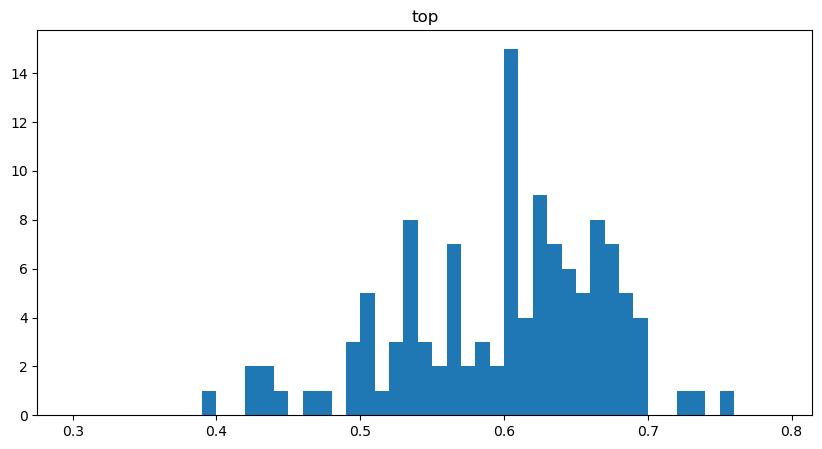

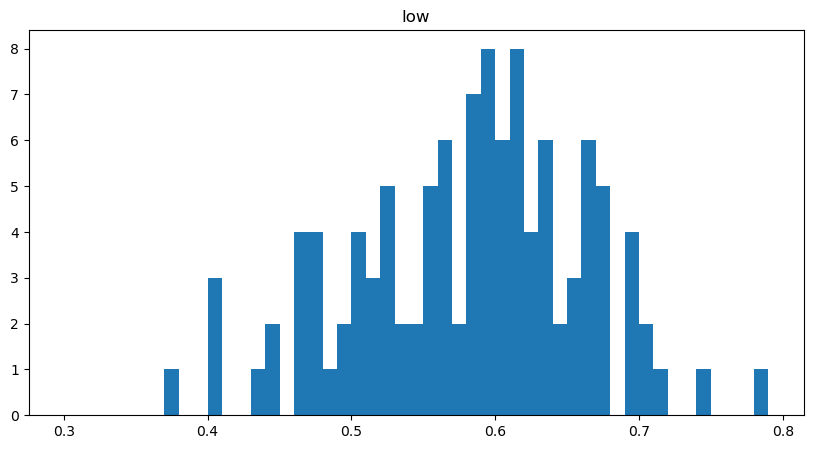

In [36]:
similarity_top, names_top = draw_and_calculate('all_tweet_user[top][agg].csv',top_text,'top')
similarity_low, names_low = draw_and_calculate('all_tweet_user[low][agg].csv',low_text,'low')

## 筛去0.5以下的用户
similarity 与 用户一一对应

In [37]:
def filter_users_remain(similarity, names, min:float) -> list:
    """
    筛选出similarity > min的人群
    """
    ret = []
    for i in tqdm(range(len(names))):
        if similarity.T[0][i] > min:
            ret.append(names[i])
    return ret

def filter_users_deleted(similarity, names, min:float) -> list:
    """
    筛选出similarity < min的人群
    """
    ret = []
    for i in tqdm(range(len(names))):
        if similarity.T[0][i] < min:
            ret.append(names[i])
    return ret

In [42]:
names_top_deleted = filter_users_deleted(similarity_top,names_top, 0.5)
names_low_deleted = filter_users_deleted(similarity_low,names_low, 0.5)

100%|██████████| 111/111 [00:00<00:00, 486486.67it/s]


In [39]:
high = pd.read_csv('high.csv')
low = pd.read_csv('low.csv')

In [49]:
# 修改 high and low
high_filtered = high[~high['Id'].isin(names_top_deleted)]
low_filtered = low[~low['Id'].isin(names_low_deleted)]

In [52]:
low_filtered.to_csv('low_filtered.csv')
high_filtered.to_csv('high_filtered.csv')

## Sample

In [54]:
# 各取出30个sample来.
high_filtered.sample(30)

,Unnamed: 0,Id
325,5220,DScottRobinson
574,5652,thisniss
597,5702,stephiec1974
171,3135,MajBinDE
584,5672,moonlightlecter
658,5919,alize4real
187,3164,KremeBoyJackson
364,5295,skyeship
544,5609,kesse77
646,5897,marissadtcch


### High Sample
P means that this person is protected or does not exist 

DScottRobinson  N   Musician?
thisniss        Y   BLM/LGBT/2020US E/ COVID19
stephiec1974    Y   LGBT
MajBinDE        Y   2024US E
moonlightlecter P
alize4real      Y
KremeBoyJackson Y   2020
skyeship        Y   2020
kesse77         Y   2020
marissadtcch    Y   LGBT
CermenoLori     Y   2020US E
RichAzzopardi   Y   Politician
cmat523         Y   D
OVOJosh         N
Llarian         P
DieselFarina    Y   2020
mattdkerr       Y
RickSAbrams     Y
LadyJayeAndi    Y
demMoMOM        Y
Ellen1317       Y
KatsAsylum      Y
abbydeaton      Y
grannyofwind    Y
CoraCarmack     N
SeegeVega       Y
MagicBullet399  Y
emma_bobo_      N
honorarrives    Y   2024
xinepie         Y

In [55]:
low_filtered.sample(30)

,Unnamed: 0,Id
514,4834,Aemok
469,4695,GizellaSpencer
483,4723,JTStevison
230,2450,Swoozie123
520,4872,TurnuptheKC
473,4703,lmh3chicksmom
272,2622,SoyLindahh
300,4195,KristieKrabe
555,4931,CollegeDemsMC
559,4935,CarolOttBarraza


Aemok           N   
GizellaSpencer  Y   2016USE
JTStevison      Y   
Swoozie123      Y
TurnuptheKC     Y
lmh3chicksmom   Y
SoyLindahh      N
KristieKrabe    Y
CollegeDemsMC   Y
CarolOttBarraza Y   2020US E
kdshae_         Y
hollys016       Y
brooketobroch   P
WritingVikingr  Y
DJGuerra81      Y
strawbannashake P
RedArm2         Y
lorosoria       N
HecsBrewed      N
CristytheQueen  Y
nattydreds1     Y
LKleindienst    Y
StefferG        Y
Shaunoon        Y
GinaTinney      Y
memememe1927    Y
_amandaroy      Y
scifinut77      Y
EricLaValle     N
nucIearduck     N